# Clustering Argo profiles using a Profile Classification Model (PCM; Maze et al., 2017)

### Import some libraries

In [5]:
import os,sys
import nbformat as nbf
import numpy as np
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate

from datetime import datetime

# run clustering algorithms for T/S, using PCA as dimension reduction
from sklearn import preprocessing#, mixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

# import colormaps
from palettable.colorbrewer.diverging import PRGn_10 as prg
from palettable.colorbrewer.sequential import GnBu_9 as gb
from palettable.colorbrewer.sequential import YlOrRd_9 as ord
from palettable.colorbrewer.sequential import YlGnBu_9 as ord2
from palettable.colorbrewer.diverging import RdYlBu_10 as ryb
from palettable.colorbrewer.diverging import RdBu_10 as rb
from palettable.colorbrewer.qualitative import Pastel2_5 as past
from palettable.cmocean.sequential import Dense_4 as dense
from palettable.colorbrewer.qualitative import Accent_4 as acc
from palettable.colorbrewer.qualitative import Set2_6 as set2
from palettable.colorbrewer.qualitative import Accent_5 as acc5
from palettable.colorbrewer.qualitative import Set1_3 as set

from palettable.cmocean.sequential import Deep_3 as deep3
from palettable.colorbrewer.qualitative import Paired_4 as paired

import invisible_cells as ic

In [5]:
import cm
import gsw

In [7]:
ic.toggle_cell()
maindir     = '/Volumes/5TB isa backup/data'
ETOPO       = os.path.join(maindir,'ETOPO1/ETOPO1_Ice_g_gmt4.grd')
floatdir    = os.path.join(maindir,'argo/South_Indian_Ocean_single_files')
dirRdm      = os.path.join(maindir,'SOCCOM_floats/rdm')
folder_argo = os.path.join(maindir,'argo/profilesIO')

plotdir     = '/Users/Isa/Documents/SOCCOM_floats/plots/KP/gmm/ipynb'
# import cm colorbars
sys.path.append('/Users/Isa/Documents/PYTHON/cmocean/cmocean')

# import gsw library
sys.path.append('/Users/Isa/Documents/PYTHON/gsw-3.0.3')

In [6]:
save_bin_dens_floats= False
save_bin_dens_argo = False
save_argo_files = False
run_argo    = False
comp_rdm    = False
tt_split    = False

regions     = range(1,9)

### Load bathymetry data (from ETOPO), for the Indian sector of the Southern Ocean

In [7]:
data        = nc.Dataset(ETOPO)
XC          = data.variables['x'][:]
YC          = data.variables['y'][:]
bathy       = data.variables['z'][:]
bathy       = np.ma.masked_greater(bathy,0.)
bathy       = -bathy
v           = np.linspace(0,6,7)
x1          = np.min(np.where(XC>=0))
x2          = np.min(np.where(XC>=180))
y1          = np.min(np.where(YC>=-70))
y2          = np.min(np.where(YC>=-30))

In [8]:
labZ        = ['Subtropical Zone','Subantarctic Zone','Polar Front Zone','Antarctic-Southern Zone','Sea Ice Zone']
prop        = ['SA','TE','OXY','NO3','pH']#'DIC']
axtit       = ['SA',r'$\theta$','O$_2$','NO$_3$','pH']#'DIC']
xlab        = ['', '[$^{\circ}C$]','[$\mu$mol kg$^{-1}$]','[$\mu$mol kg$^{-1}$]','']#'[$\mu$mol kg$^{-1}$]']
regTit      = ['West','Upstream','Downstream','East']
colS        = ['green','red','royalblue','orange','m','orange']
# number of clusters
K           = 9
# Compression level for the dimensionality reduction
maxvar      = 99.9 # in %
# for plotting
ss          = np.linspace(33.5,36.5,15)
tt          = np.linspace(-3,25,15)
oo          = np.linspace(150,400,15)
ss2, tt2    = np.meshgrid(ss,tt)
s0          = gsw.sigma0(ss2,tt2)
vd          = np.arange(23,30,0.5)
xtix        = np.linspace(0,180,7)
xtix_l      = ['0']+['%iE'%(int(ii)) for ii in xtix[1:-1]]+['180']
ytix        = np.linspace(-70,-30,9)
ytix_l      = ['%iS'%(int(np.abs(ii))) for ii in ytix]
# new pressure array
press       = np.arange(2,2002,1)

In [10]:
def load_IO_argo():
    from datetime import datetime,date, timedelta
    programs = os.listdir(floatdir)
    programs = programs[1:]
    # initialize
    tot_fl      = 0
    maxNprof    = 0
    ll          = 0
    ll1         = 0
    l0          = 0
    dateFlNum   = []
    iniDate     = datetime(1950,1,1)
    minDate     = datetime(2019,1,1).toordinal()

    # initialize big arrays
    PT_dataSO   = np.nan*np.ones((822*310,2000),'>f4')
    SA_dataSO   = np.nan*np.ones((822*310,2000),'>f4')
    lon_dataSO  = np.nan*np.ones((822*310),'>f4')
    lat_dataSO  = np.nan*np.ones((822*310),'>f4')
    pr_dataSO   = np.nan*np.ones((822*2000*310),'>f4')
    yySO        = np.zeros((822*310),'int32')
    IDSO        = np.zeros((822*2000*310),'int32')

    for pp in programs:
        SO_floats = os.listdir(os.path.join(floatdir,'%s' %pp))
        for ff_SO in SO_floats:
            print ff_SO
            # @hidden_cell
            SO_prof = [f for f in os.listdir(os.path.join(floatdir,'%s/%s' %(pp,ff_SO))) if 'prof.nc' in f]
            
            tot_fl += 1
            file    = os.path.join(floatdir,'%s/%s/%s' %(pp,ff_SO,SO_prof[0]))
            data    = nc.Dataset(file)
            time    = data.variables['JULD'][:]
            lon     = data.variables['LONGITUDE'][:]
            lat     = data.variables['LATITUDE'][:]
            pressPre= data.variables['PRES_ADJUSTED'][:].transpose()
            tempPre = data.variables['TEMP_ADJUSTED'][:].transpose()
            tempQC  = data.variables['TEMP_ADJUSTED_QC'][:].transpose()
            psaPre   = data.variables['PSAL_ADJUSTED'][:].transpose()
            psaQC    = data.variables['PSAL_ADJUSTED_QC'][:].transpose()
            # have to add the good QC: [1,2,5,8]  (not in ['1','2','5','8'])
            psaPre[np.where(psaQC!='1')] = np.nan
            tempPre[np.where(tempQC!='1')] = np.nan
            # let's get rid of some profiles that are out of the indian sector
            msk1    = np.where(np.logical_and(lon>=0,lon<180))[0][:]
            msk2    = np.where(np.logical_and(lat[msk1]>-70,lat[msk1]<-30))[0][:]

            lon     = lon[msk1][msk2]
            lat     = lat[msk1][msk2]
            time    = time[msk1][msk2]
            pressPre= pressPre[:,msk1[msk2]]
            tempPre = tempPre[:,msk1[msk2]]
            psaPre  = psaPre[:,msk1[msk2]]
            if time[0] + iniDate.toordinal() < minDate:
                minDate = time[0]
            if len(lon) > maxNprof:
                maxNprof = len(lon[~np.isnan(lon)])
                flN      = ff_SO

            # interpolate
            lat       = np.ma.masked_less(lat,-90)
            lon       = np.ma.masked_less(lon,-500)
            lon[lon>360.] = lon[lon>360.]-360.
            Nprof     = np.linspace(1,len(lat),len(lat))
            # turn the variables upside down, to have from the surface to depth and not viceversa
            if any(pressPre[:10,0]>500.):
                pressPre = pressPre[::-1,:]
                psaPre   = psaPre[::-1,:]
                tempPre  = tempPre[::-1,:]
            # interpolate data on vertical grid with 1db of resolution (this is fundamental to then create profile means)
            fields    = [psaPre,tempPre]
            press     = np.nan*np.ones((2000,pressPre.shape[1]))
            for kk in range(press.shape[1]):
                press[:,kk] = np.arange(2,2002,1)
            psa   = np.nan*np.ones((press.shape),'>f4')
            temp  = np.nan*np.ones((press.shape),'>f4')

            for ii,ff in enumerate(fields):
                for nn in range(pressPre.shape[1]):
                    # only use non-nan values, otherwise it doesn't interpolate well
                    try:
                        f1 = ff[:,nn][ff[:,nn].mask==False] #ff[:,nn][~np.isnan(ff[:,nn])]
                        f2 = pressPre[:,nn][ff[:,nn].mask==False]
                    except:
                        f1 = ff[:,nn]
                        f2 = pressPre[:,nn]
                    if len(f1)==0:
                        f1 = ff[:,nn]
                        f2 = pressPre[:,nn]
                    try:
                        sp = interpolate.interp1d(f2[~np.isnan(f1)],f1[~np.isnan(f1)],kind='linear', bounds_error=False, fill_value=np.nan)
                        ff_int = sp(press[:,nn])
                        if ii == 0:
                            psa[:,nn]   = ff_int
                        elif ii == 1:
                            temp[:,nn] = ff_int
                    except:
                        print 'At profile number %i, the float %s has only 1 record valid: len(f2)=%i' %(nn,ff_SO,len(f2))

            # To compute theta, I need absolute salinity [g/kg] from practical salinity (PSS-78) [unitless] and conservative temperature.
            # To compute sigma0, I need conservative temperature and absolute salinity
            sa = np.nan*np.ones((press.shape),'>f4')
            for kk in range(press.shape[1]):
                sa[:,kk] = gsw.SA_from_SP(psa[:,kk], press[:,0], lon[kk], lat[kk])
            ptemp     = gsw.pt_from_CT(sa, temp)
            #sigma0    = gsw.sigma0(sa,temp)

            # mask out the profiles with :
            msk       = np.where(lat<-1000)
            lat[msk]  = np.nan
            lon[msk]  = np.nan
            sa[msk]   = np.nan
            sa[sa==0.]= np.nan
            ptemp[msk] = np.nan
            ptemp[temp==0.]= np.nan
            #sigma0[msk]= np.nan
            #sigma0[sigma0==0.]= np.nan

            # save the nprofiles
            NN        = np.ones((temp.shape),'int32')
            for ii in range(len(Nprof)):
                NN[:,ii]=Nprof[ii]

            lon_dataSO[ll1:ll1+len(lon)]     = lon
            lat_dataSO[ll1:ll1+len(lon)]     = lat
            PT_dataSO[ll:ll+len(sa[0,:]),:]  = ptemp.T
            SA_dataSO[ll:ll+len(sa[0,:]),:]  = sa.T
            #nnprofSO[ll:ll+len(sa[0,:])]     = Nprof
            floatID                          = int(ff_SO)*np.ones((sa.shape[1]),'int32')
            IDSO[ll:ll+len(sa[0,:])]         = floatID

            # separate seasons
            dateFl   = []
            for dd in time:
                floatDate = iniDate + timedelta(float(dd))
                #floatDate.strftime('%Y/%m/%d %H:%M:%S%z')
                dateFl.append(floatDate)
                dateFlNum = np.append(dateFlNum,floatDate.toordinal())

            yearsSO   = np.array([int(dd.year) for dd in dateFl])
            yySO[ll:ll+len(sa[0,:])] = yearsSO

            ll  = ll + len(sa[0,:])
            ll1 = ll1 + len(lon)

    # chop away the part of the array with no data
    PT_dataSO  = PT_dataSO[:ll,:]
    SA_dataSO  = SA_dataSO[:ll,:]
    IDSO       = IDSO[:ll]
    lat_dataSO = lat_dataSO[:ll]
    lon_dataSO = lon_dataSO[:ll]
    mmSO       = mmSO[:ll]
    yySO       = yySO[:ll]

    # remove entire columns of NaNs
    idBad  = []
    for ii in range(PT_dataSO.shape[0]):
        f0 = PT_dataSO[ii,:]
        f1 = f0[~np.isnan(f0)]
        if len(f1) == 0:
            idBad.append(ii)
    PT_dataSO  = np.delete(PT_dataSO,idBad,0)
    SA_dataSO  = np.delete(SA_dataSO,idBad,0)
    IDSO       = np.delete(IDSO,idBad,0)
    lon_dataSO = np.delete(lon_dataSO,idBad,0)
    lat_dataSO = np.delete(lat_dataSO,idBad,0)
    mmSO       = np.delete(mmSO,idBad,0)
    yySO       = np.delete(yySO,idBad,0)

    idBad   = []
    # Interpolate again in depth.. for some reason, some profiles have still wholes in the middle:
    for ii in range(PT_dataSO.shape[0]):
        f0 = PT_dataSO[ii,:]
        try:
            sp = interpolate.interp1d(press[~np.isnan(f0),0],f0[~np.isnan(f0)],kind='linear', bounds_error=False, fill_value=np.nan)
            PT_dataSO[ii,:]= sp(press[:,0])
            f0 = SA_dataSO[ii,:]
            sp = interpolate.interp1d(press[~np.isnan(f0),0],f0[~np.isnan(f0)],kind='linear', bounds_error=False, fill_value=np.nan)
            SA_dataSO[ii,:]= sp(press[:,0])
        except:
            idBad.append(ii)
            print ii, ' has only 1 number'
    PT_dataSO  = np.delete(PT_dataSO,idBad,0)
    SA_dataSO  = np.delete(SA_dataSO,idBad,0)
    IDSO       = np.delete(IDSO,idBad,0)
    lon_dataSO = np.delete(lon_dataSO,idBad,0)
    lat_dataSO = np.delete(lat_dataSO,idBad,0)
    mmSO       = np.delete(mmSO,idBad,0)
    yySO       = np.delete(yySO,idBad,0)
    profSO    = [PT_dataSO,SA_dataSO,lon_dataSO,lat_dataSO,IDSO]
    temporalSO= [yySO,mmSO]

    return [profSO,temporalSO]

### Function to compute the Principal Component Analysis (PCA)

In [11]:
def compute_PCA(Xn,scaler,reducer,train,comp,pr):
    if train:
        # Compute the EOFs from X normalized
        reducer = PCA(n_components=maxvar/100,svd_solver='full')
        reducer.fit(Xn)
    # Reduce the dataset (compute the y):
    Xr     = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

    # Variables of the reduced space:
    Nc     = reducer.n_components_ # Number of components retained
    EOFs   = reducer.components_   # [Nc , Nz], the P matrix
    V      = reducer.explained_variance_ratio_ # Explained variance, with 0 to 1 values
    print Xr.shape,Xn.shape

    """
    # compute whole VE for the original data
    VE = 100. * (1- np.nanvar( Xn - Xr)/np.nanvar(Xn))
    print "Xr size and VE: ",Xr.shape, VE

    # compute first 2 modes VE for the original data
    VE = 100. * (1- np.nanvar( Xn - Xr[:2] * EOFs[:2,:])/np.nanvar(Xn))
    print "Xr size and VE: ",Xr[:2].shape, VE
    """

    # We can also compute EOFs with real units this way:
    S      = np.sqrt(reducer.explained_variance_*Xn.shape[0]) # These are the singular values
    Z      = np.dot(Xn - reducer.mean_, np.transpose(reducer.components_)) # This is simply Xr or the principal components
    Ztilde = Z/np.sqrt(S) # Normalized PCs
    EOFs_real = np.dot(np.transpose(Ztilde),Xn)/Xn.shape[0] # Regression on any collection of profiles
    print EOFs_real.shape

    # Compute the RMS difference between the reconstructed and original dataset:
    Xn_reconstructed = reducer.inverse_transform(Xr)
    X_reconstructed  = scaler.inverse_transform(Xn_reconstructed)
    rms = np.sqrt(np.mean(np.square(X_reconstructed-Xn),axis=0))

    Xr_2PCAs      = np.dot(Xn, EOFs[:2,:].T)
    Xn_reconstructed_2PCAs = np.dot(Xr_2PCAs, EOFs[:2,:])

    # compute whole VE for the original data
    VE = 100. * (1- np.nanvar( Xn - Xn_reconstructed)/np.nanvar(Xn))
    print "Xr size and VE: ",Xn_reconstructed.shape, VE

    # compute first 2 modes VE for the original data
    VE = 100. * (1- np.nanvar( Xn - Xn_reconstructed_2PCAs)/np.nanvar(Xn))
    print "Xr size and VE: ",Xn_reconstructed_2PCAs .shape, VE

    print "The variance explained by each mode, computed by reducer.explained_variance_ratio_, is ", V

    #print 'The RMS of the difference between the reconstruceted and the original dataset is: ', rms
    print "\nWe reduced the dimensionality of the problem from 2000 depth levels down to %i PCs\n"%(Nc)

    style = ['-','--','.']
    if train:
        fig, ax = plt.subplots(figsize=(7,7))#, dpi=300, facecolor='w', edgecolor='k', sharey='row')
        xl = np.max(np.abs([np.min(EOFs_real),np.max(EOFs)]))
        for ie in range(0,min(2,EOFs.shape[0])):
            ax.plot(np.transpose(EOFs[ie,:]),pr,linestyle=style[ie],c='k',label="PCA-%i"%(ie+1),linewidth=2)
        #ax[iax].set_xlim(1.1*np.array([-xl,xl]))
        if 'Temp' in comp:
            ax.legend(loc=2,fancybox=True)
        ax.set_xlabel('PCAs', fontsize=14)# (no units)')
        ax.set_ylabel('pressure [db]', fontsize=14)
        ax.grid(True)
        ax.set_title('PCA components of %s' %comp,fontsize=16)
        ax.set_xlim(-0.1,0.1)
        ax.invert_yaxis()
        ax.set_ylim(1000,200)

        outfile = os.path.join(plotdir,'gmm_Indian_Ocean_PCAs_depth_%s_chopped_300_900m.png' %comp[:3])
        plt.savefig(outfile, bbox_inches='tight',dpi=200)
        plt.close()

    return [Nc,V,EOFs,EOFs_real,Xr,reducer]

### Clustering the profiles using the Gaussian Mixture Model (GMM) as classifier 

In [79]:
def run_gmm(Xr,gmm,train,K):
    if train:
        gmm = GMM(n_components=K,\
                    covariance_type='full',\
                    init_params='kmeans',\
                    max_iter=1000,\
                    random_state=1000,\
                    tol=1e-6)
        gmm.fit(Xr) # Training on reduced data

        # Extract GMM parameters:
        priors = gmm.weights_ # [K,1]
        centers= gmm.means_   # [K,Nc]
        covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

    # Classify the dataset:
    LABELS = gmm.predict(Xr) # [Np,1]
    POST   = gmm.predict_proba(Xr) # [Np,Nc]

    return [LABELS, POST,gmm]

### Plot the Bayesian Information Criterion (BIC) 
This criterion is used for model selection among a finite set of models. The model with the lowest BIC is chosen. Another selction criterion is the Akaike Information Criterion (AIC), which is not used here.

In [168]:
def plot_BIC(set):
    lowest_bic = np.infty
    bic        = []
    n_components_range = range(1, 50)
    cv_types = ['full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GMM(n_components=n_components,covariance_type=cv_type)
            gmm.fit(set)
            bic.append(gmm.bic(set))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)

    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range,bic,'k',linewidth=4,alpha=0.5)
    plt.scatter(n_components_range,bic,c='k',edgecolors='face',s=100,alpha=0.4)
    plt.scatter(n_components_range[K-1],bic[K-1],c='r',s=200,marker='*')
    plt.xlabel('# clusters')
    plt.ylabel('BIC score')
    plt.title(r"GMM BIC score, using the first 2 PCAs of $\theta$ and salinity (training set)")
    plt.grid("on")
    plt.xlim(-0.01,50.01)

    outfile = os.path.join(plotdir,'gmm_Indian_Ocean_BIC_score_training.png')
    plt.savefig(outfile, bbox_inches='tight',dpi=200)

In [22]:
def test_small_sample_BIC(PT_dataSO,SA_dataSO,PTn,SAn,scalerPT,scalerSA):
    rdm = np.nan*np.ones((10,2650))
    degRdm = 2.5
    ii = 0
    for ix in np.arange(0,180,degRdm):
        for iy in np.arange(-70,-30,degRdm):
            idx = np.where(np.logical_and(np.logical_and(np.logical_and(lon_dataSO>=ix,lon_dataSO<ix+degRdm),lat_dataSO>=iy),lat_dataSO<iy+degRdm))[0][:]
            try:
                for zz in range(10):
                    tmp = np.random.choice(idx,1)
                    rdm[zz,ii] = tmp
                ii += 1
            except:
                print 'no Argo in %.1fiE-%.1fE, %.1fS-%.1fS' %(ix,ix+degRdm,iy,iy+degRdm)

    col         = ['r','c','m','green','b','orange','yellowgreen','gray','pink','lime','royalblue','slateblue','crimson','yellowgreen','peru']
    ## to check that it does produce always the same list, run the code twice, plotting the results on top of each other
    for kk in range(10):
        i1 = np.where(~np.isnan(rdm[kk,:]))[:][0]
        irdm = [int(rr) for rr in rdm[kk,i1]]
        plt.figure(1)
        plt.scatter(lon_dataSO[irdm],lat_dataSO[irdm],c=col[kk],s=50,marker='*',edgecolor='None',alpha=0.5)

    plt.show()

    bicV        = np.nan*np.ones((10,29))
    for kk in range(10):
        i1 = np.where(~np.isnan(rdm[kk,:]))[:][0]
        irdm = [int(rr) for rr in rdm[kk,i1]]
        PTn_tr  = PTn[irdm,:]
        SAn_tr  = SAn[irdm,:]

        # reduce the training set
        [Nc_PT,V_PT,EOFs_PT,EOFs_real_PT,PTtr_r,reducerPT] = compute_PCA(PTn_tr,scalerPT,None,1,'Potential Temperature',press[idz1:idz2])
        [Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SAtr_r,reducerSA] = compute_PCA(SAn_tr,scalerSA,None,1,'Absolute Salinity',press[idz1:idz2])

        # select only the first 2 PCAs of PT and SA to build the array for the gmm algorithm
        # 2 PCAs
        # training
        set = np.zeros((PTtr_r.shape[0],4))
        set[...,0] = PTtr_r[:,0]
        set[...,1] = PTtr_r[:,1]
        set[...,2] = SAtr_r[:,0]
        set[...,3] = SAtr_r[:,1]

        # BIC score
        lowest_bic = np.infty
        bic        = []
        n_components_range = range(1, 30)
        cv_types = ['full']
        for cv_type in cv_types:
            for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
                gmm = GMM(n_components=n_components,covariance_type=cv_type)
                gmm.fit(set)
                bic.append(gmm.bic(set))
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm

        bic = np.array(bic)
        bicV[kk,:] = bic

    # Plot the BIC scores
    plt.figure(1,figsize=(8, 6))
    plt.errorbar(n_components_range,np.nanmean(bicV,0),yerr=np.nanstd(bicV,0),ecolor='m',elinewidth=3, capsize=2)
    plt.scatter(n_components_range,np.nanmean(bicV,0),c='k',marker='o',edgecolors='face',s=10,alpha=0.4)
    plt.xlabel('# clusters')
    plt.ylabel('BIC score')
    plt.title(r"GMM BIC score, 1% of data")
    plt.grid("on")
    plt.xlim(-0.01,30.01)

    outfile = os.path.join(plotdir,'gmm_Indian_Ocean_BIC_score_training_10samples_1pc.png')
    plt.savefig(outfile, bbox_inches='tight',dpi=200)
    plt.show()

## Run the PCA

In [17]:
######################## TRAIN and PREDICT ARGO ########################
filePT  = os.path.join(folder_argo,'PT_dataSO.npz')
fileSA  = os.path.join(folder_argo,'SA_dataSO.npz')
fileSP  = os.path.join(folder_argo,'SP_dataSO.npz')
fileS0  = os.path.join(folder_argo,'dens_dataSO.npz')
fileID  = os.path.join(folder_argo,'IDSO.npz')
fileLON = os.path.join(folder_argo,'lon_dataSO.npz')
fileLAT = os.path.join(folder_argo,'lat_dataSO.npz')
fileYY  = os.path.join(folder_argo,'years_dataSO.npz')
if run_argo:
    # load the profiles 
    if indian:
        [profSO,temporalSO] = load_IO_argo()
    else:
        [profSO,temporalSO] = load_SO_argo()
    # all depth profiles
    PT_dataSO  = profSO[0]
    SA_dataSO  = profSO[1]
    lon_dataSO = profSO[2]
    lat_dataSO = profSO[3]
    IDSO       = profSO[4]
    # years
    years_dataSO = temporalSO[0]

    # chop between 300 m and 1000 m.. more or less. There should be all numbers, and no Nans...
    # trying with only a subset (in vertical) of the profiles
    # First search for those floats that have Nans Between 200 and 1200 m
    id1,id2    = np.where(np.isnan(PT_dataSO[:,198:1199]))

    # then, remove the floats where the first not NaN value is deeper than 300 or the deepest is shallower than 900 m
    idBadNew   = []
    for ii in np.unique(id1):
        if not(press[np.min(np.where(~np.isnan(PT_dataSO[ii,:])))]<=300. and press[np.max(np.where(~np.isnan(PT_dataSO[ii,:])))]>=900):
            idBadNew.append(ii)
    PT_dataSO  = np.delete(PT_dataSO,idBadNew,0)
    SA_dataSO  = np.delete(SA_dataSO,idBadNew,0)
    IDSO       = np.delete(IDSO,idBadNew,0)
    lon_dataSO = np.delete(lon_dataSO,idBadNew,0)
    lat_dataSO = np.delete(lat_dataSO,idBadNew,0)
    years_dataSO= np.delete(years_dataSO,idBadNew,0)

    # sigma_theta (from Absolute Salinity and Conservative Temperature!!)
    CT_dataSO    = gsw.CT_from_pt(SA_dataSO, PT_dataSO)
    dens_dataSO  = gsw.sigma0(SA_dataSO,CT_dataSO)

    # save compressed files:
    np.savez_compressed(filePT, PT_dataSO=PT_dataSO)
    np.savez_compressed(fileSA, SA_dataSO=SA_dataSO)
    np.savez_compressed(fileS0, dens_dataSO=dens_dataSO)
    np.savez_compressed(fileID, IDSO=IDSO)
    np.savez_compressed(fileLON, lon_dataSO=lon_dataSO)
    np.savez_compressed(fileLAT, lat_dataSO=lat_dataSO)
    np.savez_compressed(fileYY,years_dataSO=years_dataSO)
else:
    # load compressed files
    PT_dataSO  = np.load(filePT)['PT_dataSO']
    SA_dataSO  = np.load(fileSA)['SA_dataSO']
    SP_dataSO  = np.load(fileSP)['SP_dataSO']
    dens_dataSO= np.load(fileS0)['dens_dataSO']
    IDSO       = np.load(fileID)['IDSO']
    lon_dataSO = np.load(fileLON)['lon_dataSO']
    lat_dataSO = np.load(fileLAT)['lat_dataSO']
    years_dataSO = np.load(fileYY)['years_dataSO']

### Now, fit the scaler object between 300 and 900 m, in order to standardize dataset by removing the mean and scaling to unit variance:


In [19]:
idz1      = np.min(np.where(press>=300.))
idz2      = np.min(np.where(press>=900.))
scalerPT  = preprocessing.StandardScaler()
scalerPT  = scalerPT.fit(PT_dataSO[:,idz1:idz2])
scalerSA  = preprocessing.StandardScaler()
scalerSA  = scalerSA.fit(SA_dataSO[:,idz1:idz2])
scalerSP  = preprocessing.StandardScaler()
scalerSP  = scalerSP.fit(SP_dataSO[:,idz1:idz2])

# remove entire columns of NaNs
PT_dataSO[np.where(SA_dataSO<33)]= np.nan
SA_dataSO[np.where(SA_dataSO<33)]= np.nan
idBad  = []
for ii in range(SA_dataSO.shape[0]):
    f0 = SA_dataSO[ii,:]
    f1 = f0[~np.isnan(f0)]
    if len(f1) == 0:
        idBad.append(ii)
PT_dataSO  = np.delete(PT_dataSO,idBad,0)
SA_dataSO  = np.delete(SA_dataSO,idBad,0)
SP_dataSO  = np.delete(SA_dataSO,idBad,0)
lon_dataSO = np.delete(lon_dataSO,idBad,0)
lat_dataSO = np.delete(lat_dataSO,idBad,0)
dens_dataSO= np.delete(dens_dataSO,idBad,0)
IDSO       = np.delete(IDSO,idBad,0)
years_dataSO = np.delete(years_dataSO,idBad,0)

# Mean and std profiles for the chopped profiles:
mean_PT   = scalerPT.mean_
std_PT    = scalerPT.scale_
mean_SA   = scalerSA.mean_
std_SA    = scalerSA.scale_
mean_SP   = scalerSP.mean_
std_SP    = scalerSP.scale_

# Normalize the chopped profiles
PTn       = scalerPT.transform(PT_dataSO[:,idz1:idz2])
SAn       = scalerSA.transform(SA_dataSO[:,idz1:idz2])

# take only the training set
if tt_split:
    # Can use the train_test_split() function, but this does not assure that we'll have a coherent distribution.
    # better to randomly select a profile every 1degx1deg (see after)
    X       = PT_dataSO[:,100]
    y       = range(len(X))
    X_train, X_test, rdm, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rdm     = np.array(rdm)
else:
    # randomly select a profile every 0.1degx0.1deg
    outfileRdm = os.path.join(dirRdm,'random_89percent.npz')
    if comp_rdm:
        rdm = []
        degRdm = 0.1
        for ix in np.arange(0,180,degRdm):
            for iy in np.arange(-70,-30,degRdm):
                idx = np.where(np.logical_and(np.logical_and(np.logical_and(lon_dataSO>=ix,lon_dataSO<ix+degRdm),lat_dataSO>=iy),lat_dataSO<iy+degRdm))[0][:]
                try:
                    tmp = np.random.choice(idx,1)
                    rdm = np.append(rdm,tmp)
                except:
                    print 'no Argo in %.1fiE-%.1fE, %.1fS-%.1fS' %(ix,ix+degRdm,iy,iy+degRdm)

        rdm  = np.array([int(ii) for ii in rdm])
        np.savez(outfileRdm,rdm)
    else:
        npzfile = np.load(outfileRdm)
        rdm     = npzfile['arr_0']
## to check that it does produce always the same list, run the code twice, plotting the results on top of each other
#plt.scatter(lon_dataSO[rdm],lat_dataSO[rdm],c='c',s=3,edgecolor='None')

PTn_tr  = PTn[rdm,:]
SAn_tr  = SAn[rdm,:]

# Extract mean and std of SA and THETA of the whole profiles
mean_PT_t   = np.nanmean(PT_dataSO,axis=0)
std_PT_t    = np.nanstd(PT_dataSO,axis=0)
mean_SA_t   = np.nanmean(SA_dataSO,axis=0)
std_SA_t    = np.nanstd(SA_dataSO,axis=0)

/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


### Reduce the profiles using the PCA:

In [68]:
# get the training set
PTtr    = PT_dataSO[rdm,:]
SAtr    = SA_dataSO[rdm,:]

# reduce the training set
[Nc_PT,V_PT,EOFs_PT,EOFs_real_PT,PTtr_r,reducerPT] = compute_PCA(PTn_tr,scalerPT,None,1,'Potential Temperature',press[idz1:idz2])
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SAtr_r,reducerSA] = compute_PCA(SAn_tr,scalerSA,None,1,'Absolute Salinity',press[idz1:idz2])
# reduce the full dataset:
[Nc_PT,V_PT,EOFs_PT,EOFs_real_PT,PT_r,reducerPT]   = compute_PCA(PTn,scalerPT,reducerPT,0,'Potential Temperature',None)
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SA_r,reducerSA]   = compute_PCA(SAn,scalerSA,reducerSA,0,'Absolute Salinity',None)

# 2 PCAs
# training
setTr_r = np.zeros((PTtr_r.shape[0],4))
setTr_r[...,0] = PTtr_r[:,0]
setTr_r[...,1] = PTtr_r[:,1]
setTr_r[...,2] = SAtr_r[:,0]
setTr_r[...,3] = SAtr_r[:,1]
# full
set_r = np.zeros((PT_r.shape[0],4))
set_r[...,0] = PT_r[:,0]
set_r[...,1] = PT_r[:,1]
set_r[...,2] = SA_r[:,0]
set_r[...,3] = SA_r[:,1]

(87032, 3) (87032, 600)
(3, 600)
Xr size and VE:  (87032, 600) 99.9105368926
Xr size and VE:  (87032, 600) 99.7044958052
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.97923606  0.01780899  0.00206032]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs

(87032, 7) (87032, 600)
(7, 600)
Xr size and VE:  (87032, 600) 99.9057414116
Xr size and VE:  (87032, 600) 98.687873362
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.96992603e-01   1.89884929e-01   8.60454033e-03   2.02877623e-03
   8.08585835e-04   4.50885315e-04   2.86955041e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs

(99925, 3) (99925, 600)
(3, 600)
Xr size and VE:  (99925, 600) 99.9086702232
Xr size and VE:  (99925, 600) 99.696693624
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.97923606  0.01780899  0.00206032]

We reduc

### How much does S add? Compute the cross correlation between the different modes (note: I think that it would be very helpful to check in different regions, because I think the cross correlation is higher in the ACC, where S doesn't add much to the method, but lower in the subtropics and close to Antarctica)

In [108]:
print 'cross correlation between PCA1_PT and PCA1_SA = ', np.corrcoef(PT_r[:,0],SA_r[:,0])[0,1]
print 'cross correlation between PCA1_PT and PCA2_SA = ', np.corrcoef(PT_r[:,0],SA_r[:,1])[0,1]
print 'cross correlation between PCA2_PT and PCA2_SA = ', np.corrcoef(PT_r[:,1],SA_r[:,1])[0,1]
print 'cross correlation xbetween PCA2_PT and PCA1_SA = ', np.corrcoef(PT_r[:,1],SA_r[:,0])[0,1]

cross correlation between PCA1_PT and PCA1_SA =  0.492839959011
cross correlation between PCA1_PT and PCA2_SA =  -0.753924443431
cross correlation between PCA2_PT and PCA2_SA =  -0.496399267298
cross correlation between PCA2_PT and PCA1_SA =  -0.193622100466


### Compute the BIC score for the selected model and test it for a range of models 

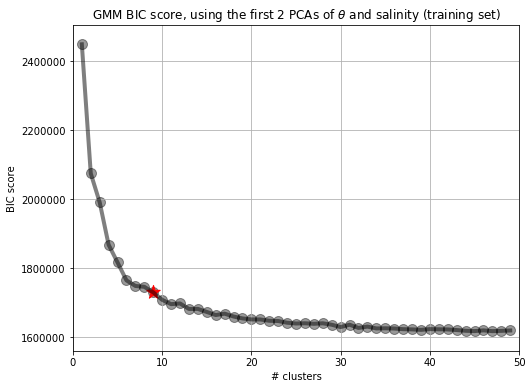

In [23]:
# plot BIC score
plot_BIC(setTr_r)

no Argo in 5.0iE-7.5E, -62.5S--60.0S
no Argo in 5.0iE-7.5E, -60.0S--57.5S
no Argo in 7.5iE-10.0E, -65.0S--62.5S
no Argo in 7.5iE-10.0E, -60.0S--57.5S
no Argo in 10.0iE-12.5E, -65.0S--62.5S
no Argo in 10.0iE-12.5E, -60.0S--57.5S
no Argo in 12.5iE-15.0E, -65.0S--62.5S
no Argo in 15.0iE-17.5E, -65.0S--62.5S
no Argo in 15.0iE-17.5E, -60.0S--57.5S
no Argo in 17.5iE-20.0E, -67.5S--65.0S
no Argo in 17.5iE-20.0E, -65.0S--62.5S
no Argo in 17.5iE-20.0E, -32.5S--30.0S
no Argo in 20.0iE-22.5E, -67.5S--65.0S
no Argo in 20.0iE-22.5E, -65.0S--62.5S
no Argo in 20.0iE-22.5E, -35.0S--32.5S
no Argo in 20.0iE-22.5E, -32.5S--30.0S
no Argo in 22.5iE-25.0E, -67.5S--65.0S
no Argo in 22.5iE-25.0E, -65.0S--62.5S
no Argo in 22.5iE-25.0E, -32.5S--30.0S
no Argo in 25.0iE-27.5E, -67.5S--65.0S
no Argo in 25.0iE-27.5E, -65.0S--62.5S
no Argo in 25.0iE-27.5E, -62.5S--60.0S
no Argo in 25.0iE-27.5E, -32.5S--30.0S
no Argo in 27.5iE-30.0E, -65.0S--62.5S
no Argo in 27.5iE-30.0E, -62.5S--60.0S
no Argo in 30.0iE-32.5E, -65.0S

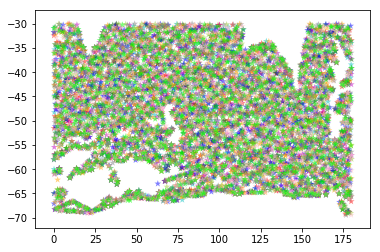

(995, 3) (995, 600)
(3, 600)
Xr size and VE:  (995, 600) 99.9347970543
Xr size and VE:  (995, 600) 99.7925866336
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98594924  0.01198511  0.00141362]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs

(995, 6) (995, 600)
(6, 600)
Xr size and VE:  (995, 600) 99.9044360751
Xr size and VE:  (995, 600) 98.9395497923
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.57322545e-01   2.31798558e-01   7.02947994e-03   1.70123824e-03
   7.56544607e-04   3.99678070e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 6 PCs

(995, 3) (995, 600)
(3, 600)
Xr size and VE:  (995, 600) 99.9374258829
Xr size and VE:  (995, 600) 99.7870756887
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.9858082   0.01207998  0.00148607]

We reduced the dimensionality of the problem fr

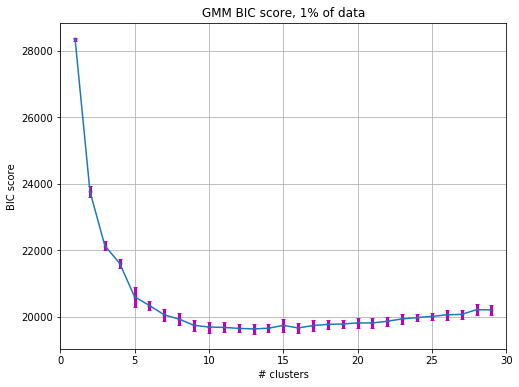

In [24]:
# test BIC score for a sub-sample fo the training set
test_small_sample_BIC(PT_dataSO,SA_dataSO,PTn,SAn,scalerPT,scalerSA)

## Run the GMM and extract the parameters, labels and probabilities

In [70]:
# run the gmm of the training set
[labels_tr,post_tr,gmm]    = run_gmm(setTr_r,'',1,K)
# Classify the dataset:
[labels,post,gmm]          = run_gmm(set_r,gmm,0,K)

# extract the optimal parameters
lambda_k               = gmm.weights_ 		# dimension = n_components = 9
mean_k                 = gmm.means_			# dimension = n_components x n_features = 9 x 4
cov_k                  = gmm.covariances_	# dimension = n_components x n_features x n_features = 9 x 4 x 4

## Plot some maps

In [85]:
# map of clusters
def plot_clusters(labels,lon,lat,typeP,K):
    col         = ['r','c','pink','green','b','orange','yellowgreen','gray','magenta','lime','royalblue','slateblue','crimson','yellowgreen','peru']

    fig,ax   = plt.subplots(figsize=(12,7))
    ax.contour(XC[x1:x2], YC[y1:y2],bathy[y1:y2,x1:x2],[0,10,20],colors='k')
    ax.set_xlim(XC[x1],XC[x2])
    ax.set_ylim(YC[y1],YC[y2])
    ax.set_title('Clusters of Argo floats in the Indian sector of the Southern Ocean',fontsize=16)
    for ii in range(K):
        idx = np.where(labels==ii)[0][:]
        ax.scatter(lon[idx],lat[idx],c=col[ii],s=5,edgecolor='None',alpha=0.9)
        ax.plot(np.nan,np.nan,c=col[ii],linewidth=2,label='%i' %(ii+1))
    leg = ax.legend(loc=3,ncol=3,fancybox=True,framealpha=0.8)

    outfile = os.path.join(plotdir,'gmm_Indian_Ocean_Argo_clusters_map_%s.png' %(typeP))
    plt.savefig(outfile, bbox_inches='tight',dpi=200)
    plt.show()

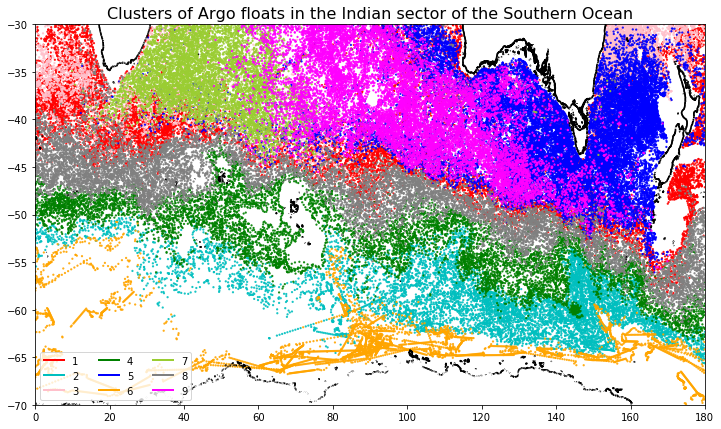

In [86]:
plot_clusters(labels,lon_dataSO,lat_dataSO,'T_S',K)

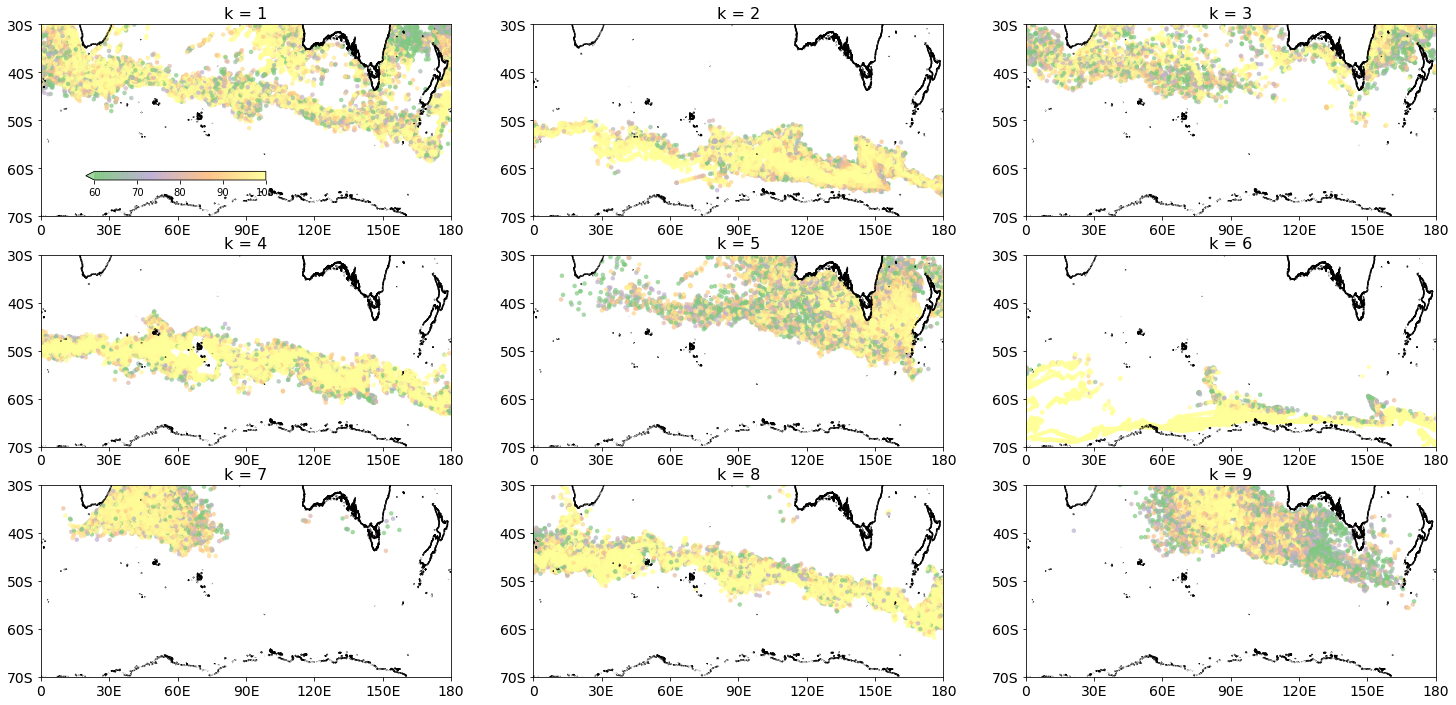

In [35]:
# map of clusters with post probab
fig      = plt.figure(figsize=(25,12))
for ii in range(K):
    ax       = plt.subplot(3,3,ii+1)
    ax.contour(XC[x1:x2], YC[y1:y2],bathy[y1:y2,x1:x2],[0,10,20],colors='k')
    ax.set_xlim(XC[x1],XC[x2])
    ax.set_ylim(YC[y1],YC[y2])
    ax.set_title('k = %i' %(ii+1),fontsize=16)
    idx = np.where(labels==ii)[0][:]
    im = ax.scatter(lon_dataSO[idx],lat_dataSO[idx],c=post[idx,ii]*100.,s=20,edgecolor='None',alpha=0.7,cmap=acc.mpl_colormap) #acc.mpl_colormap)
    im.set_clim(60,100)
    if ii == 8:
        cax     = fig.add_axes([0.15, 0.7, 0.1, 0.01])
        cbar    = plt.colorbar(im,cax=cax,orientation='horizontal',extend='min')
        cbar.ax.xaxis.set_tick_params(color='k')
        cbar.set_ticks(np.linspace(60,100,5))  
    ax.set_xticks(xtix)
    ax.set_xticklabels(xtix_l,fontsize=14)
    ax.set_yticks(ytix[::2])
    ax.set_yticklabels(ytix_l[::2],fontsize=14) 

outfile = os.path.join(plotdir,'gmm_Indian_Ocean_Argo_clusters_map_post.png')
plt.savefig(outfile, bbox_inches='tight',dpi=200)
plt.show()

### plot total probabilities histograms

1 21.636390686
2 7.96411409974
3 42.9831534624
4 7.69892185926
5 21.915884316
6 8.86966139078
7 10.2990224957
8 8.94983783364
9 44.6819931269


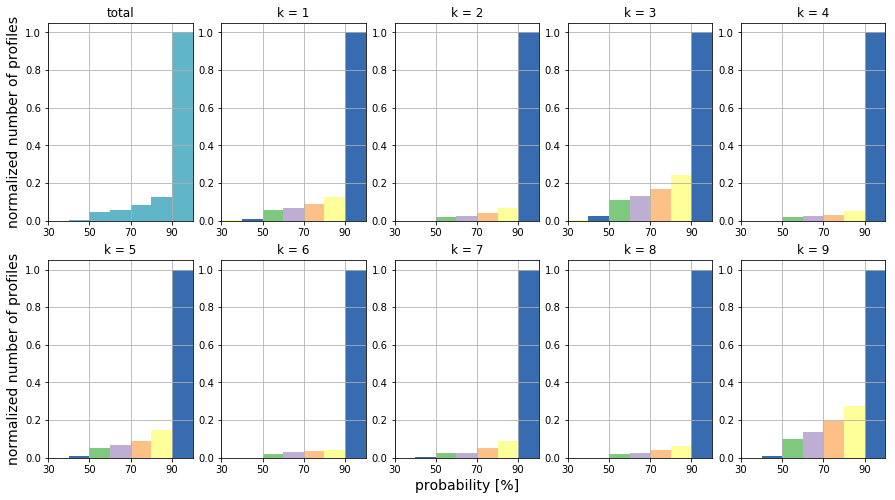

In [39]:
cmpR     = mpl.colors.ListedColormap(acc5.mpl_colors)
prob_tot = []
bins     = np.arange(0,1.1,0.1)
bins_mid = (bins[:-1]+bins[1:])/2.
prob_bin = np.nan*np.ones((len(bins_mid)),'>f4')
prob_binT= np.nan*np.ones((len(bins_mid)),'>f4')
colors   = cmpR(np.linspace(0, 1, 5))
plt.figure(figsize=(15,8))
for ii in range(K):
    idx = np.where(labels==ii)[0][:]
    for jj,bb in enumerate(bins[:-1]):
        ff  = post[idx,ii]
        idj = np.where(np.logical_and(ff>=bb,ff<bb+0.1))[0][:]
        prob_bin[jj] = np.nansum(ff[idj])
    print ii+1, np.nansum(prob_bin[:8]/prob_bin[-1])*100
    prob_tot = np.append(prob_tot,post[idx,ii])
    plt.subplot(2,5,ii+2)
    plt.bar(bins_mid*100.,prob_bin/prob_bin[-1],width=0.1*100,color=colors,align='center')		
    plt.grid(True)
    plt.xticks(np.arange(30,120,20))
    plt.title("k = %i" %(ii+1))
    if ii in [6]:
        plt.xlabel('probability [%]',fontsize=14)
    if ii == 4:
        plt.ylabel('normalized number of profiles',fontsize=14)
    plt.xlim(30,100)
for jj,bb in enumerate(bins[:-1]):
    idj = np.where(np.logical_and(prob_tot>=bb,prob_tot<bb+0.1))[0][:]
    prob_binT[jj] = np.nansum(prob_tot[idj])
plt.subplot(2,5,1)
plt.title("total")
plt.grid(True)
plt.xticks(np.arange(30,120,20))
plt.ylabel('normalized number of profiles',fontsize=14)
plt.bar(bins_mid*100.,prob_binT/prob_binT[-1],width=0.1*100,color='#1D98AE',alpha=0.7,align='center')		
plt.xlim(30,100)

outfile = os.path.join(plotdir,'gmm_Indian_Ocean_prob_hist.png')
plt.savefig(outfile, bbox_inches='tight',dpi=200)
plt.show()

### Plot fuzziness

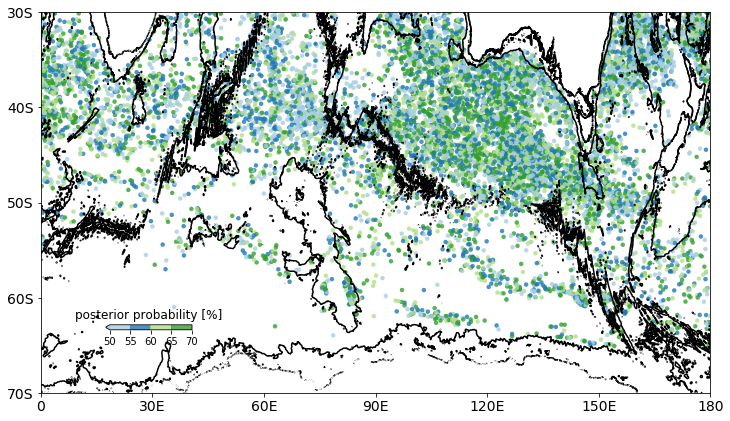

In [49]:
cmp      = mpl.colors.ListedColormap(paired.mpl_colors)

fig      = plt.figure(figsize=(12,7))
ax       = plt.subplot(111)
plt.contour(XC[x1:x2], YC[y1:y2],bathy[y1:y2,x1:x2],[0,10,20,3000],colors='k')
for ii in range(K):
    tmp = np.delete(range(K),ii)
    for jj in tmp:
        id_k = np.where(np.logical_and(labels==ii,post[:,ii]<=0.7))[:][0]  
        idx  = np.where(post[id_k,jj]>=0.3)[:][0]
        im=plt.scatter(lon_dataSO[id_k][idx],lat_dataSO[id_k][idx],c=post[id_k,ii][idx]*100,s=20,edgecolor='None',alpha=0.8,cmap=cmp)
        im.set_clim(50,70)
        ax.set_xlim(XC[x1],XC[x2])
        ax.set_ylim(YC[y1],YC[y2])
    if ii == 8:
        cax     = fig.add_axes([0.2, 0.25, 0.1, 0.01])
        cbar    = plt.colorbar(im,cax=cax,orientation='horizontal',extend='min')
        cbar.ax.xaxis.set_tick_params(color='k')
        cbar.set_ticks(np.linspace(50,70,5))  
        cbar.ax.set_title('posterior probability [%]')
        ax.set_xticks(xtix)
        ax.set_xticklabels(xtix_l,fontsize=14)
        ax.set_yticks(ytix[::2])
        ax.set_yticklabels(ytix_l[::2],fontsize=14) 

outfile = os.path.join(plotdir,'gmm_Indian_Ocean_Argo_clusters_map_all_post_fuzzy.png')
plt.savefig(outfile, bbox_inches='tight',dpi=200)
plt.show()

## Repeat analysis for T and S combined: Q = [T S]

### Since we found that the cross-correlation between the 2 modes of T and shows a not insignificant value, let's check what the combined field looks like

In [121]:
# combine T and S
Q       = np.zeros((PT_dataSO.shape[0],2*(idz2-idz1)),'>f4')
Q[:,:idz2-idz1] = PT_dataSO[:,idz1:idz2]
Q[:,idz2-idz1:] = SA_dataSO[:,idz1:idz2]

# normalize Q
scalerQ = preprocessing.StandardScaler()
scalerQ = scalerQ.fit(Q)
Qn      = scalerQ.transform(Q)

# extract training set using the rdm set defined before
Qn_tr   = Qn[rdm,:]
Qtr     = Q[rdm,:]

In [147]:
# build a new pressure array, with pressure levels repeated (since T and S are concatenated)
press2 = np.concatenate([press[idz1:idz2]]*2)
print 'The new pressure array has a dimension of',press2.shape[0]

# reduce the training set
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Qtr_r,reducerQ] = compute_PCA(Qn_tr,scalerQ,None,1,'Q = [T S]',press2)
# reduce the full dataset:
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Q_r,reducerQ]   = compute_PCA(Qn,scalerQ,reducerQ,0,'Q = [T S]',press2)

The new pressure array has a dimension of 1200
(87032, 8) (87032, 1200)
(8, 1200)
Xr size and VE:  (87032, 1200) 99.9060663964
Xr size and VE:  (87032, 1200) 96.5997685214
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.94726861e-01   2.71265084e-01   2.56593679e-02   4.34414464e-03
   1.52697953e-03   8.46476825e-04   4.38564691e-04   2.52987038e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 8 PCs

(99925, 8) (99925, 1200)
(8, 1200)
Xr size and VE:  (99925, 1200) 99.9045639476
Xr size and VE:  (99925, 1200) 96.508728159
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.94726861e-01   2.71265084e-01   2.56593679e-02   4.34414464e-03
   1.52697953e-03   8.46476825e-04   4.38564691e-04   2.52987038e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 8 PCs



In [176]:
print 'The first 3 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02],'of the variance.'
print 'The first 4 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02 + 4.34414464e-03],'of the variance.'

The first 3 modes explain [0.9916513129000001] of the variance.
The first 4 modes explain [0.9959954575400001] of the variance.


### The first 3 PCAs of Q explain 99% of the variance. Let's work with these!

In [169]:
# 3 PCAs
# training
setTrQ_r = np.zeros((Qtr_r.shape[0],3))
setTrQ_r[...,0] = Qtr_r[:,0]
setTrQ_r[...,1] = Qtr_r[:,1]
setTrQ_r[...,2] = Qtr_r[:,0]
# full
setQ_r = np.zeros((Q_r.shape[0],3))
setQ_r[...,0] = Q_r[:,0]
setQ_r[...,1] = Q_r[:,1]
setQ_r[...,2] = Q_r[:,0]

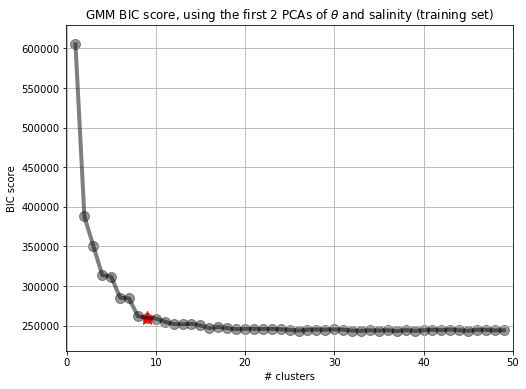

In [170]:
# plot the BIC
plot_BIC(setTrQ_r)

In [174]:
# run the gmm of the training set
[labels_Qtr,post_Qtr,gmmQ]    = run_gmm(setTrQ_r,'',1,K)
# Classify the dataset:
[labelsQ,postQ,gmmQ]          = run_gmm(setQ_r,gmmQ,0,K)

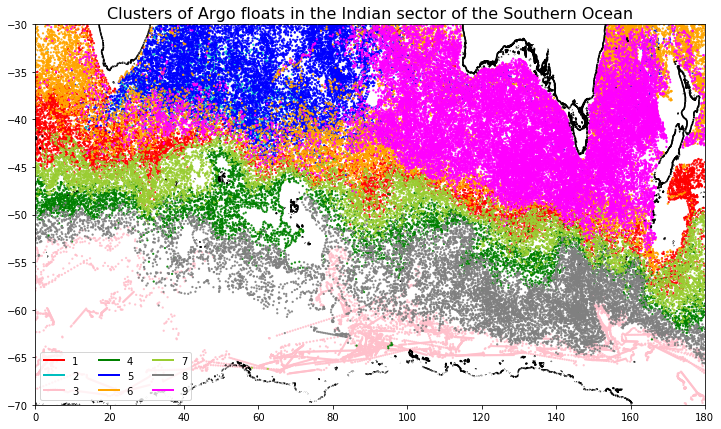

In [175]:
# plot the clusters
plot_clusters(labelsQ,lon_dataSO,lat_dataSO,'Q',K)

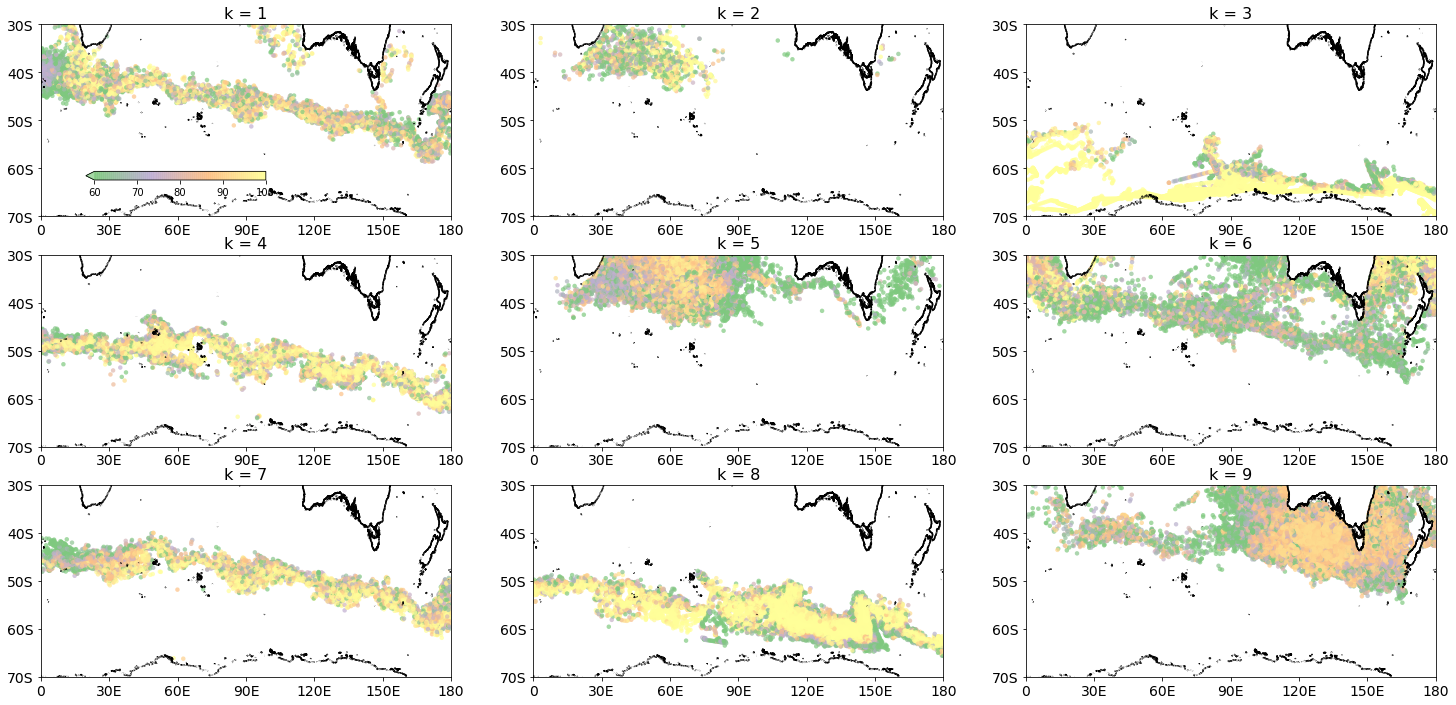

In [177]:
# map of clusters with post probab
fig      = plt.figure(figsize=(25,12))
for ii in range(K):
    ax       = plt.subplot(3,3,ii+1)
    ax.contour(XC[x1:x2], YC[y1:y2],bathy[y1:y2,x1:x2],[0,10,20],colors='k')
    ax.set_xlim(XC[x1],XC[x2])
    ax.set_ylim(YC[y1],YC[y2])
    ax.set_title('k = %i' %(ii+1),fontsize=16)
    idx = np.where(labelsQ==ii)[0][:]
    im = ax.scatter(lon_dataSO[idx],lat_dataSO[idx],c=postQ[idx,ii]*100.,s=20,edgecolor='None',alpha=0.7,cmap=acc.mpl_colormap)
    im.set_clim(60,100)
    if ii == 8:
        cax     = fig.add_axes([0.15, 0.7, 0.1, 0.01])
        cbar    = plt.colorbar(im,cax=cax,orientation='horizontal',extend='min')
        cbar.ax.xaxis.set_tick_params(color='k')
        cbar.set_ticks(np.linspace(60,100,5))  
    ax.set_xticks(xtix)
    ax.set_xticklabels(xtix_l,fontsize=14)
    ax.set_yticks(ytix[::2])
    ax.set_yticklabels(ytix_l[::2],fontsize=14) 

outfile = os.path.join(plotdir,'gmm_Indian_Ocean_Argo_clusters_map_post_Q.png')
plt.savefig(outfile, bbox_inches='tight',dpi=200)
plt.show()